In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
events = pd.read_csv('../dataset/events.csv')
props = pd.read_csv('../dataset/item_properties.csv')

prices = props[props['property'] == '790'].copy()
prices['price'] = prices['value'].apply(lambda x: float(x.replace('n', '')))
prices = prices[['itemid', 'timestamp', 'price']].sort_values('timestamp')

events = events.sort_values('timestamp')
events_full = pd.merge_asof(
    events,
    prices,
    left_on='timestamp',
    right_on='timestamp',
    by='itemid',
    direction='nearest', # Hoặc backward
    tolerance=pd.Timedelta('100000 days').value // 1000000 # convert days to ms nếu timestamp là ms
)

events_full

,timestamp,visitorid,event,itemid,transactionid,price
0,1430622004384,693516,addtocart,297662,NaN,14280.0
1,1430622011289,829044,view,60987,NaN,204120.0
2,1430622013048,652699,view,252860,NaN,NaN
3,1430622024154,1125936,view,33661,NaN,32640.0
4,1430622026228,693516,view,297662,NaN,14280.0
...,...,...,...,...,...,...
2756096,1442545164029,472345,view,301436,NaN,21120.0
2756097,1442545165499,1207677,view,310922,NaN,23760.0
2756098,1442545174109,255126,view,47467,NaN,134520.0
2756099,1442545181778,622226,view,345308,NaN,20400.0


In [3]:
events_full[
    (events_full['event'] == 'transaction') &
    (events_full['price'].isna())
]

,timestamp,visitorid,event,itemid,transactionid,price
591,1430624101772,345781,transaction,438400,1016.0,NaN
9763,1430684695946,53842,transaction,336945,9606.0,NaN
12240,1430692866732,163561,transaction,386635,6042.0,NaN
20459,1430721167315,849941,transaction,104432,848.0,NaN
25363,1430761687717,681196,transaction,122734,9964.0,NaN
...,...,...,...,...,...,...
2737070,1442405560865,672066,transaction,243343,5942.0,NaN
2740750,1442430063333,748697,transaction,110645,6281.0,NaN
2748831,1442503061050,748562,transaction,344902,9155.0,NaN
2749784,1442508532165,871243,transaction,386523,2750.0,NaN


In [4]:
events_full.to_csv('../dataset/events_full_with_price.csv', index=False)

In [5]:
df = pd.read_csv('../dataset/events_full_with_price.csv')
if 'timestamp' in df.columns:
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')

current_date = df['datetime'].max() + pd.Timedelta(days=1)
global_avg_price = df['price'].mean()
df['price'] = df['price'].fillna(global_avg_price)
df[
    (df['event'] == 'transaction') &
    (df['price'].isna())
]

,timestamp,visitorid,event,itemid,transactionid,price,datetime


In [6]:
df['is_view'] = (df['event'] == 'view').astype(int)
df['is_cart'] = (df['event'] == 'addtocart').astype(int)
df['is_buy']  = (df['event'] == 'transaction').astype(int)

# Giá trị tiền chỉ tính khi MUA, nhưng giá trị quan tâm (Interest) tính cả khi XEM
df['revenue'] = df['price'] * df['is_buy'] 

df['view_value'] = df['price'] * df['is_view'] # Để tính trung bình giá các món họ xem
df.head(2)

df[df['visitorid']==1407579]

,timestamp,visitorid,event,itemid,transactionid,price,datetime,is_view,is_cart,is_buy,revenue,view_value
1081804,1435184526978,1407579,view,2521,NaN,66000.0,2015-06-24 22:22:06.978,1,0,0,0.0,66000.0


In [7]:
# Aggregation: Xây dựng chân dung khách hàng trên các khía cạnh
user_profile = df.groupby('visitorid').agg({
    'datetime': lambda x: (current_date - x.max()).days, # Recency (lần cuối tương tác bất kỳ)
    'is_view': 'sum',      # Tổng lượt xem
    'is_cart': 'sum',      # Tổng lượt thêm giỏ
    'is_buy': 'sum',       # Frequency (Số đơn mua)
    'revenue': 'sum',      # Monetary (Tổng tiền chi)
    'view_value': 'mean'   # Avg_Interest_Price: Trung bình giá những món họ xem (Gu đắt hay rẻ)
}).reset_index()

user_profile.columns = ['visitorid', 'Recency', 'View_Count', 'Cart_Count', 'Frequency', 'Monetary', 'Avg_View_Price']
user_profile

,visitorid,Recency,View_Count,Cart_Count,Frequency,Monetary,Avg_View_Price
0,0,7,3,0,0,0.0,368360.000000
1,1,36,1,0,0,0.0,354960.000000
2,2,42,8,0,0,0.0,50355.000000
3,3,48,1,0,0,0.0,13680.000000
4,4,3,1,0,0,0.0,158799.081775
...,...,...,...,...,...,...,...
1407575,1407575,100,1,0,0,0.0,41160.000000
1407576,1407576,107,1,0,0,0.0,20400.000000
1407577,1407577,124,1,0,0,0.0,9360.000000
1407578,1407578,125,1,0,0,0.0,100560.000000


In [8]:
# Feature Enrichment: Tính các chỉ số phái sinh (Ratio)
# Conversion Rate: Tỷ lệ Mua / (Xem + Cart)
user_profile['Conversion_Rate'] = user_profile['Frequency'] / (user_profile['View_Count'] + user_profile['Cart_Count'] + 1)
user_profile.fillna(0, inplace=True)
print("Shape:", user_profile.shape)
display(user_profile.head())

Shape: (1407580, 8)


,visitorid,Recency,View_Count,Cart_Count,Frequency,Monetary,Avg_View_Price,Conversion_Rate
0,0,7,3,0,0,0.0,368360.000000,0.0
1,1,36,1,0,0,0.0,354960.000000,0.0
2,2,42,8,0,0,0.0,50355.000000,0.0
3,3,48,1,0,0,0.0,13680.000000,0.0
4,4,3,1,0,0,0.0,158799.081775,0.0


In [9]:
print(user_profile[['Recency', 'Frequency', 'Monetary']].skew())

Recency        0.026087
Frequency    364.657158
Monetary     367.531158
dtype: float64


## 1.Standardization

- Most customers buy once or twice, a few buy all the time\n
- Đa số khách chi ít, 1 số chi nhiều (Pareto82/Whales)

* Capping không hiệu quả

In [10]:
# ufc = user_profile.copy()
# upper_threshold = 0.99167
# cap_F = ufc['Frequency'].quantile(upper_threshold)
# cap_M = ufc['Monetary'].quantile(upper_threshold)
# print(f"Ngưỡng trần (99.5%): F <= {cap_F}, M <= {cap_M:,.0f}")

# ufc['F_capped'] = ufc['Frequency'].clip(upper=cap_F)
# ufc['M_capped'] = ufc['Monetary'].clip(upper=cap_M)
# # Recency thường không cần cap, nhưng nếu thích thì cap luôn (cắt đuôi bên phải - người quá lâu không mua)
# cap_R = ufc['Recency'].quantile(upper_threshold)
# ufc['R_capped'] = ufc['Recency'].clip(upper=cap_R)

# # log lên capped
# ufc['F_log'] = np.log1p(ufc['F_capped'])
# ufc['M_log'] = np.log1p(ufc['M_capped'])
# # print(ufc[['Recency', 'Frequency', 'Monetary']].skew())
# # check sk
# print("\n--- Độ lệch (Skewness) sau khi Cap 95% + Log ---")
# print(ufc[['Recency', 'F_log', 'M_log']].skew())
# # MỤC TIÊU: Kết quả tuyệt đối < 2.0 là OK. Nếu < 1.0 là TUYỆT VỜI.

* Sử dụng rank-gauss - đọc slide 3 trang 20

In [11]:
upc = user_profile.copy()
cols = ['Recency', 'Frequency', 'Monetary']

# ======================================================
# BƯỚC QUAN TRỌNG: THÊM NHIỄU (JITTERING)
# ======================================================
# Cộng một số ngẫu nhiên siêu nhỏ (từ 0 đến 0.01) vào dữ liệu
# Để phá vỡ các giá trị trùng nhau (nhất là Frequency = 1)
np.random.seed(42)
upc['Frequency'] = upc['Frequency'] + np.random.uniform(0, 0.01, size=len(upc))
upc['Monetary'] = upc['Monetary'] + np.random.uniform(0, 0.01, size=len(upc))
# Recency cũng nên làm để cho mượt hẳn
upc['Recency'] = upc['Recency'] + np.random.uniform(0, 0.01, size=len(upc))

# ======================================================
# CHẠY LẠI QUANTILE TRANSFORMER
# ======================================================
qt = QuantileTransformer(n_quantiles=2000, output_distribution='normal', random_state=42)

X_gauss = qt.fit_transform(upc[cols])
X_gauss = pd.DataFrame(X_gauss, columns=[c + '_gauss' for c in cols])

# Check lại kết quả (Lần này sẽ đẹp)
print("--- Skewness sau khi thêm Jitter + Rank Gauss ---")
print(X_gauss.skew())

display(X_gauss.head())

--- Skewness sau khi thêm Jitter + Rank Gauss ---
Recency_gauss     -0.021095
Frequency_gauss   -0.033999
Monetary_gauss    -0.002265
dtype: float64


,Recency_gauss,Frequency_gauss,Monetary_gauss
0,-1.688098,-0.331446,0.081311
1,-0.651277,1.577946,-2.159177
2,-0.536750,0.614549,0.974578
3,-0.411854,0.242300,-0.444405
4,-2.240090,-1.002136,-0.618648


In [12]:
corr_matrix = upc[['Frequency', 'Monetary']].corr()
print(f"Correlation Coef F-M: {corr_matrix.iloc[0,1]:.4f} ")
# -> dễ bias cho trục F-M này (Euclidean)


Correlation Coef F-M: 0.9634 


## 2.PCA projection

--- Data after PCA (X_pca) ---
        PC1       PC2       PC3
0 -0.118926 -1.701201  0.303900
1 -0.391975 -0.705644 -2.641413
2  1.132858 -0.497396  0.255685
3 -0.136855 -0.432827 -0.486837
4 -1.064392 -2.293070  0.288145

---Explained Variance Ratio ---
[0.35507641 0.33001815 0.31490545]
Sum of explained variance ratio: 100.00%


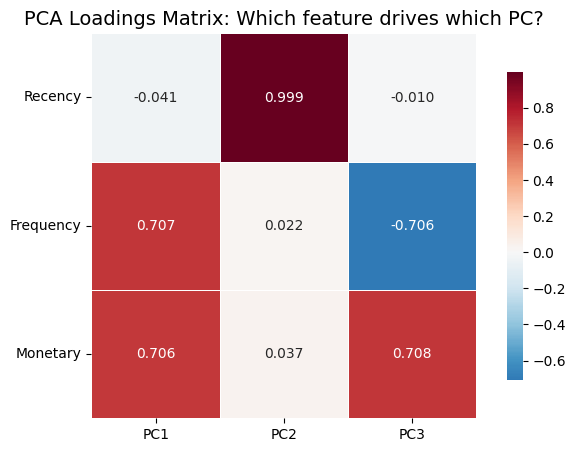

In [13]:
pca = PCA(n_components=3)
# fit transform
X_pca_array = pca.fit_transform(X_gauss)
X_pca = pd.DataFrame(X_pca_array, columns=['PC1', 'PC2', 'PC3'])
# Test result
print("--- Data after PCA (X_pca) ---")
print(X_pca.head())

print("\n---Explained Variance Ratio ---")
print(pca.explained_variance_ratio_)
print(f"Sum of explained variance ratio: {sum(pca.explained_variance_ratio_)*100:.2f}%")
# Meaning of each PC (Loading Matrix)
# Để biết PC1 đại diện for 
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2', 'PC3'], 
    index=cols
)
plt.figure(figsize=(8, 5))

sns.heatmap(loadings, annot=True, cmap='RdBu_r', center=0, fmt='.3f', 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})

plt.title('PCA Loadings Matrix: Which feature drives which PC?', fontsize=14)
plt.yticks(rotation=0) 
plt.show()

PC1: Đại diện cho "Sức Mua & Giá Trị" (Value Component),gom thành công F và M lại làm một

PC2 đã tách biệt hoàn toàn yếu tố thời gian ra khỏi tiền bạc. PC2 càng cao $\rightarrow$ Khách càng lâu không quay lại (Nguy cơ rời bỏ). Đây chính là trục "Rủi ro Churn".

PC3: Đại diện cho "Hành vi chi tiêu" (Spending Behavior)Nó là sự đối nghịch giữa Monetary (0.7) và Frequency (-0.7).$\rightarrow$ Ý nghĩa: Thành phần này phân biệt giữa "Người mua ít nhưng mua đồ đắt" (Monetary cao, Frequency thấp) và "Người mua lắt nhắt đồ rẻ" (Monetary thấp, Frequency cao).


## 3. K-means

* Elbow-methods

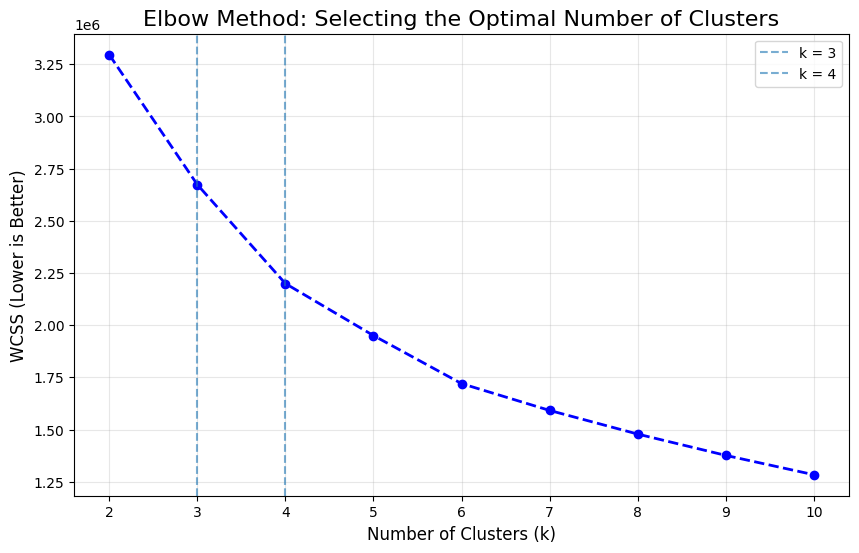

In [14]:
# List to store WCSS (Within-Cluster Sum of Squares)
wcss = []
k_range = range(2, 11)  # Try k from 2 to 10 clusters

for k in k_range:
    # random_state ensures reproducibility
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        random_state=42,
        n_init=10
    )
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(
    k_range,
    wcss,
    marker='o',
    linestyle='--',
    linewidth=2,
    color = 'b'
)

plt.title('Elbow Method: Selecting the Optimal Number of Clusters', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('WCSS (Lower is Better)', fontsize=12)
plt.xticks(k_range)
plt.grid(True, alpha=0.3)

# Highlight potential optimal k values
plt.axvline(x=3, linestyle='--', alpha=0.6, label='k = 3')
plt.axvline(x=4, linestyle='--', alpha=0.6, label='k = 4')

plt.legend()
plt.show()


In [15]:
# Sample the data to save time/memory bc (Calculating distance matrix for 1.4M rows is extremely heavy)
sample_size = 50000
if len(X_pca) > sample_size:
    print(f"Sampling {sample_size} rows for Silhouette calculation...")
    X_sample = X_pca.sample(n=sample_size, random_state=42)
else:
    X_sample = X_pca

print("-" * 50)
print("Calculating Silhouette Scores (Higher is better)...")
print("-" * 50)

# 2. Loop through candidate k values
candidate_k = [3, 4, 5, 6]

for k in candidate_k:
    # Run K-Means
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_sample)
    
    # Calculate Silhouette Score
    score = silhouette_score(X_sample, labels)
    
    print(f"k = {k} | Silhouette Score = {score:.4f}")

print("-" * 50)

Sampling 50000 rows for Silhouette calculation...
--------------------------------------------------
Calculating Silhouette Scores (Higher is better)...
--------------------------------------------------
k = 3 | Silhouette Score = 0.2132
k = 4 | Silhouette Score = 0.2247
k = 5 | Silhouette Score = 0.2214
k = 6 | Silhouette Score = 0.2249
--------------------------------------------------


--- CLUSTER PROFILES (Average Values) ---


,Cluster,Recency,Frequency,Monetary,Count
0,0,87.89,0.01,0.00,363316
1,1,85.00,0.00,0.01,356020
2,2,79.98,0.07,7123.50,342274
3,3,21.46,0.00,0.57,345970


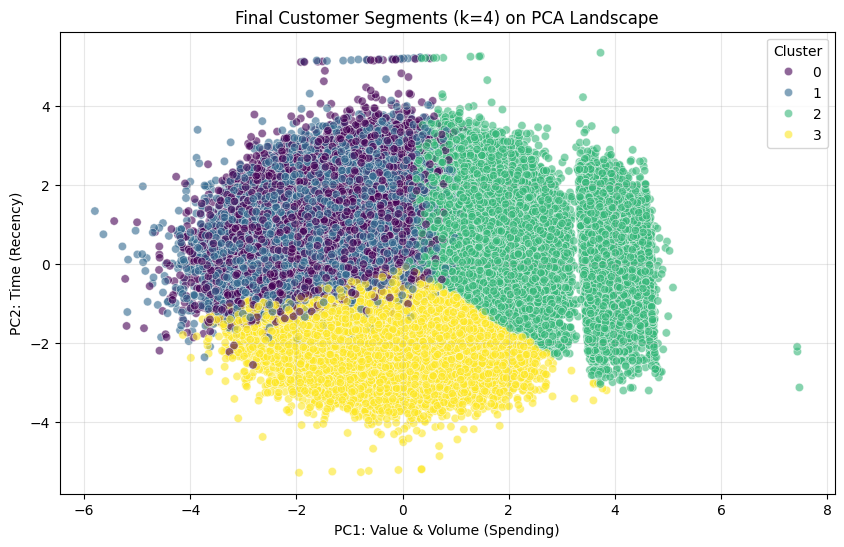

In [16]:
# =========================================================
# 1. RUN FINAL K-MEANS WITH K=4
# =========================================================
# n_init=10 ensures we find a stable solution
kmeans_final = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)

# Fit on the PCA data
kmeans_final.fit(X_pca)

# Assign cluster labels back to the ORIGINAL dataframe (upc)
# This connects the math back to the business data
upc['Cluster'] = kmeans_final.labels_

# =========================================================
# 2. CLUSTER PROFILING (THE MOST IMPORTANT PART)
# =========================================================
# We calculate the mean Recency, Frequency, and Monetary for each cluster
# This table tells us "Who is Cluster 0? Who is Cluster 1?"
cluster_profile = upc.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

# Count number of customers in each cluster
cluster_size = upc['Cluster'].value_counts().reset_index()
cluster_size.columns = ['Cluster', 'Count']

# Merge to see everything in one table
profile_table = cluster_profile.merge(cluster_size, on='Cluster')

print("--- CLUSTER PROFILES (Average Values) ---")
display(profile_table.round(2))

# =========================================================
# 3. VISUALIZE THE SEGMENTS
# =========================================================
# Let's see how they look on the PC1 vs PC2 map
plt.figure(figsize=(10, 6))
sns.scatterplot(data=X_pca, x='PC1', y='PC2', hue=upc['Cluster'], palette='viridis', alpha=0.6)
plt.title('Final Customer Segments (k=4) on PCA Landscape')
plt.xlabel('PC1: Value & Volume (Spending)')
plt.ylabel('PC2: Time (Recency)')
plt.legend(title='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

Tại sao lại tách ra? Đây là do kỹ thuật "Jitter" (thêm nhiễu) cộng với thuật toán K-Means cố gắng chia đều phương sai

"Mỏ Vàng đang Rỉ Máu" (High Value At-Risk). Đây chính là nhóm VIP, nguồn sống của doanh nghiệp, CẢNH BÁO ĐỎ (Recency ~80 ngày): Đây là insight quan trọng nhất. Khách VIP của bạn đang có Recency ~80 ngày, tức là gần 3 tháng rồi họ chưa quay lại!Monetary cao chứng tỏ mỗi lần mua họ chi rất đậm.VIP đang rời bỏ (Churning VIPs). Cần báo động gấp!

Cụm 3: "Dòng máu mới" (Fresh Prospects)
Recency (~21 ngày): Thấp nhất bảng. Đây là những người mới vào gần đây.
Monetary (~0.57): Chưa chi tiền nhiều.
Kết luận: Đây là khách tiềm năng (Prospects). Họ mới biết đến bạn, đang xem hàng nhưng chưa chốt đơn to.

In [17]:
upc

,visitorid,Recency,View_Count,Cart_Count,Frequency,Monetary,Avg_View_Price,Conversion_Rate,Cluster
0,0,7.008326,3,0,0.003745,0.005291,368360.000000,0.0,3
1,1,36.008036,1,0,0.009507,0.000147,354960.000000,0.0,0
2,2,42.001909,8,0,0.007320,0.008390,50355.000000,0.0,2
3,3,48.005011,1,0,0.005987,0.003314,13680.000000,0.0,3
4,4,3.002361,1,0,0.001560,0.002708,158799.081775,0.0,3
...,...,...,...,...,...,...,...,...,...
1407575,1407575,100.005981,1,0,0.007627,0.006493,41160.000000,0.0,2
1407576,1407576,107.004550,1,0,0.007283,0.004872,20400.000000,0.0,2
1407577,1407577,124.002221,1,0,0.007150,0.002803,9360.000000,0.0,0
1407578,1407578,125.003416,1,0,0.009387,0.000233,100560.000000,0.0,0


## 4. Profile & Name

In [18]:
# 1. Define Standard Business Names (Mapping)
# Strategy: Merge Cluster 0 and 1 for cleaner reporting
segment_names = {
    0: 'Lost / Inactive',
    1: 'Lost / Inactive',
    2: 'High Value At-Risk',  # Highlight At-Risk factor due to high Recency
    3: 'New Prospects'
}

# 2. Map names to the DataFrame
upc['Segment'] = upc['Cluster'].map(segment_names)

# 3. Recalculate Statistics by New Segment
segment_profile = upc.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().round(2)
segment_count = upc['Segment'].value_counts()

print("--- FINAL STATISTICS ---")
display(segment_profile)
print("\nCustomer Counts:")
print(segment_count)


--- FINAL STATISTICS ---


,Recency,Frequency,Monetary
Segment,,,
High Value At-Risk,79.98,0.07,7123.50
Lost / Inactive,86.46,0.00,0.00
New Prospects,21.46,0.00,0.57



Customer Counts:
Segment
Lost / Inactive       719336
New Prospects         345970
High Value At-Risk    342274
Name: count, dtype: int64


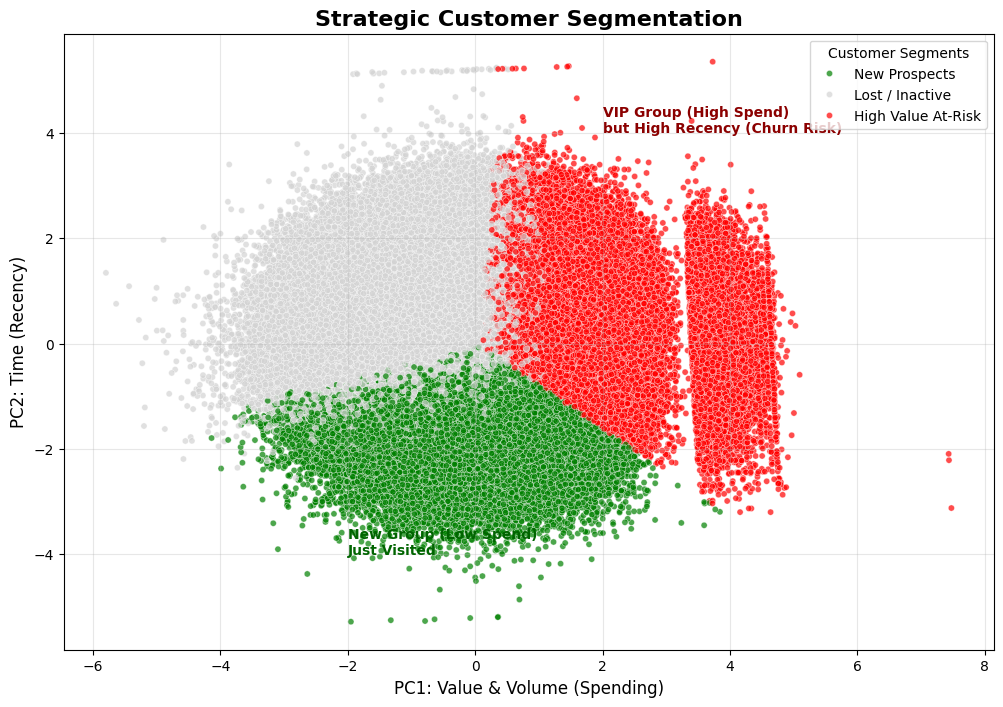

In [19]:
# 4. Plot Final Chart
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=X_pca, 
    x='PC1', 
    y='PC2', 
    hue=upc['Segment'], 
    palette={
        'Lost / Inactive': 'lightgray',      # Neutral color for background
        'High Value At-Risk': 'red',         # Alarm color
        'New Prospects': 'green'             # Hopeful color
    },
    alpha=0.7,
    s=20
)

plt.title('Strategic Customer Segmentation', fontsize=16, fontweight='bold')
plt.xlabel('PC1: Value & Volume (Spending)', fontsize=12)
plt.ylabel('PC2: Time (Recency)', fontsize=12)
plt.legend(title='Customer Segments', loc='upper right')
plt.grid(True, alpha=0.3)

plt.text(x=2, y=4, s="VIP Group (High Spend)\nbut High Recency (Churn Risk)", color='darkred', fontsize=10, fontweight='bold')
plt.text(x=-2, y=-4, s="New Group (Low Spend)\nJust Visited", color='darkgreen', fontsize=10, fontweight='bold')

plt.show()

In [20]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Tạo khung hình 3D
# fig = plt.figure(figsize=(12, 10))
# ax = fig.add_subplot(111, projection='3d')

# # Lấy dữ liệu màu sắc theo Segment đã gộp
# # Map màu: Lost (Xám), At-Risk (Đỏ), New (Xanh)
# colors = upc['Segment'].map({
#     'Lost / Inactive': 'lightgray',
#     'High Value At-Risk': 'red',
#     'New Prospects': 'green'
# })

# # Vẽ Scatter 3D
# # Trục X: PC1, Trục Y: PC2, Trục Z: PC3
# scatter = ax.scatter(X_pca['PC1'], X_pca['PC2'], X_pca['PC3'], 
#                      c=colors, s=20, alpha=0.6)

# # Đặt tên trục
# ax.set_xlabel('PC1: Value')
# ax.set_ylabel('PC2: Time ')
# ax.set_zlabel('PC3: Spending Behavior')

# ax.set_title('3D Visualization of Customer Segments')

# # Góc nhìn (Thay đổi để xoay biểu đồ)
# ax.view_init(elev=30, azim=45) 

# plt.show()

## GMM 

Đang tìm số cụm tối ưu cho GMM (dựa trên BIC/AIC)...


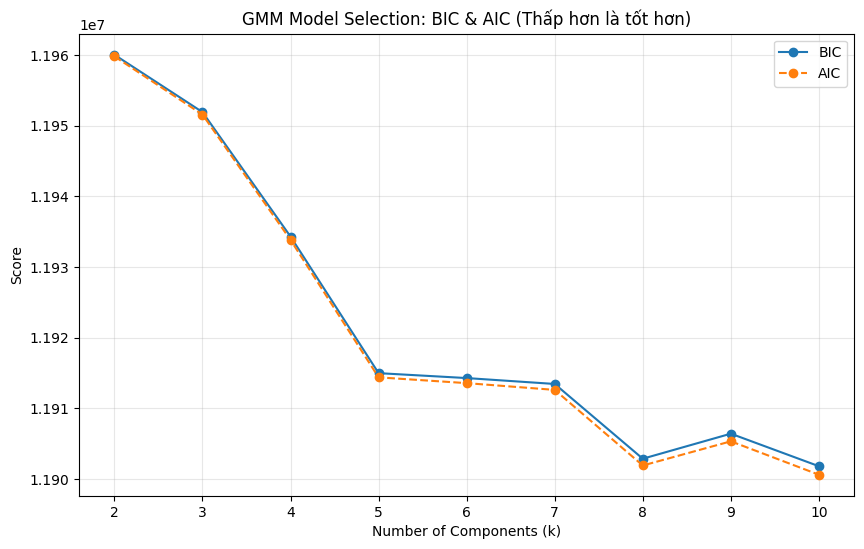

In [21]:
from sklearn.mixture import GaussianMixture
n_components = range(2, 11)
bic_scores = []
aic_scores = []
print("Đang tìm số cụm tối ưu cho GMM (dựa trên BIC/AIC)...")

for n in n_components:
    # covariance_type='full': Cho phép các cụm có hình dạng elip tùy ý (linh hoạt nhất)
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X_pca)
    bic_scores.append(gmm.bic(X_pca))
    aic_scores.append(gmm.aic(X_pca))

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(n_components, bic_scores, label='BIC', marker='o')
plt.plot(n_components, aic_scores, label='AIC', marker='o', linestyle='--')
plt.title('GMM Model Selection: BIC & AIC (Thấp hơn là tốt hơn)')
plt.xlabel('Number of Components (k)')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Số lượng khách hàng nằm ở vùng 'ranh giới' (Uncertain): 782654
Ví dụ 5 khách hàng khó phân loại nhất:


,Prob_0,Prob_1,Prob_2,Prob_3
0,0.09,0.23,0.19,0.48
1,0.29,0.13,0.55,0.03
2,0.54,0.19,0.01,0.26
3,0.55,0.33,0.09,0.02
4,0.23,0.38,0.11,0.28


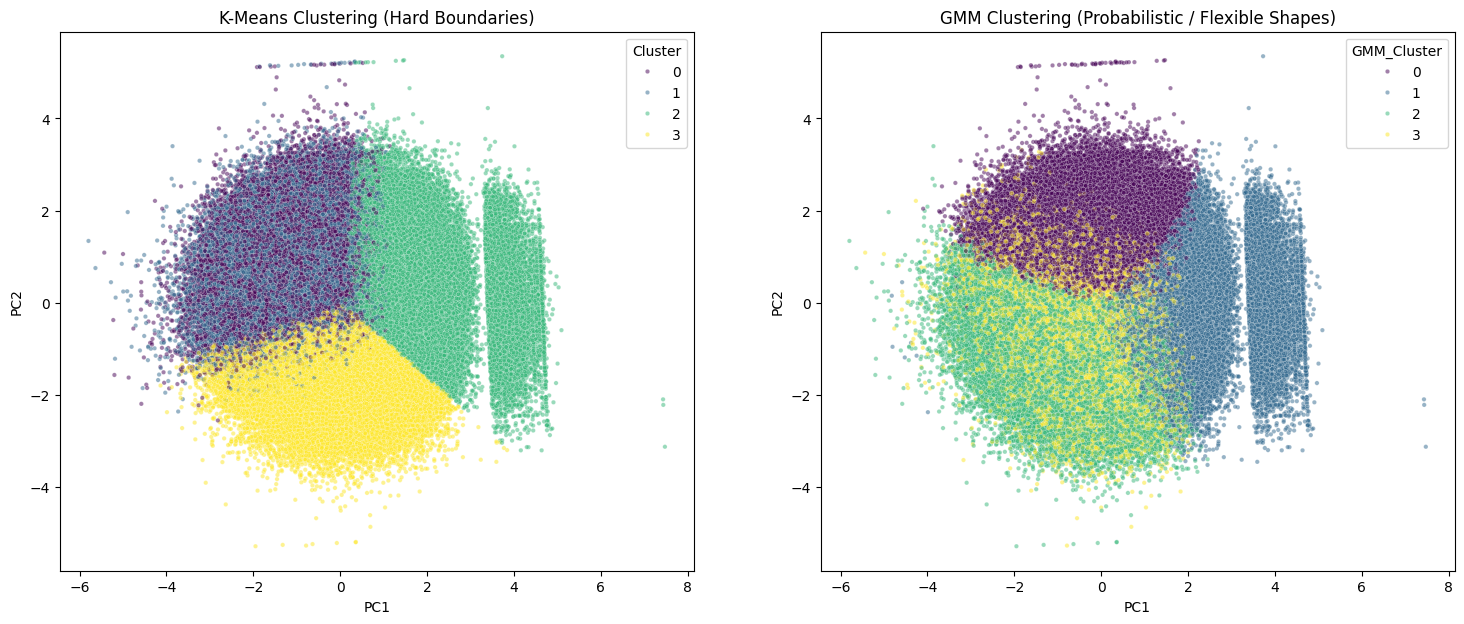

In [22]:
# 1. Chạy GMM với k=4
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(X_pca)

# Gán nhãn vào DataFrame
upc['GMM_Cluster'] = gmm_labels

# 2. "Killer Feature": Xem xác suất thuộc về từng cụm
# probs là ma trận: Mỗi dòng là 1 khách hàng, 4 cột là xác suất thuộc về 4 cụm
probs = gmm.predict_proba(X_pca)

# Lấy ra những khách hàng "lưỡng lự" (Không chắc chắn 100% thuộc về cụm nào)
# Ví dụ: Max xác suất < 0.6 (tức là máy cũng đang phân vân)
uncertain_mask = probs.max(axis=1) < 0.6
uncertain_customers = upc[uncertain_mask].copy()

print(f"Số lượng khách hàng nằm ở vùng 'ranh giới' (Uncertain): {len(uncertain_customers)}")
print("Ví dụ 5 khách hàng khó phân loại nhất:")
# Hiển thị xác suất của 5 người này
display(pd.DataFrame(probs[uncertain_mask][:5], columns=['Prob_0', 'Prob_1', 'Prob_2', 'Prob_3']).round(2))

# 3. Vẽ biểu đồ so sánh K-Means vs GMM
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot K-Means
sns.scatterplot(data=X_pca, x='PC1', y='PC2', hue=upc['Cluster'], palette='viridis', ax=axes[0], alpha=0.5, s=10)
axes[0].set_title('K-Means Clustering (Hard Boundaries)')

# Plot GMM
sns.scatterplot(data=X_pca, x='PC1', y='PC2', hue=upc['GMM_Cluster'], palette='viridis', ax=axes[1], alpha=0.5, s=10)
axes[1].set_title('GMM Clustering (Probabilistic / Flexible Shapes)')

plt.show()

In [23]:
# 1. Chạy GMM với K=5 (Theo gợi ý của BIC)
gmm_5 = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
gmm_labels = gmm_5.fit_predict(X_pca)

# Gán nhãn vào data gốc để soi
upc['GMM_Cluster_5'] = gmm_labels

# 2. Xem Profile (Trung bình R, F, M)
gmm_profile = upc.groupby('GMM_Cluster_5')[['Recency', 'Frequency', 'Monetary']].mean().round(2)
gmm_count = upc['GMM_Cluster_5'].value_counts().reset_index()
gmm_count.columns = ['GMM_Cluster_5', 'Count']

# 3. Hiển thị kết quả
print("--- GMM PROFILE (K=5) ---")
display(gmm_profile.merge(gmm_count, on='GMM_Cluster_5').sort_values('Monetary', ascending=False))

--- GMM PROFILE (K=5) ---


,GMM_Cluster_5,Recency,Frequency,Monetary,Count
4,4,67.30,0.22,23409.04,104164
0,0,112.10,0.00,0.01,322584
1,1,38.08,0.00,0.01,351564
2,2,68.26,0.00,0.00,252547
3,3,61.57,0.01,0.00,376721


"Siêu VIP" (Whales) Top 1% khách hàng quan trọng nhất.
"Khách cũ từng mua nay đã bỏ" và "Khách vãng lai chưa bao giờ mua". với 

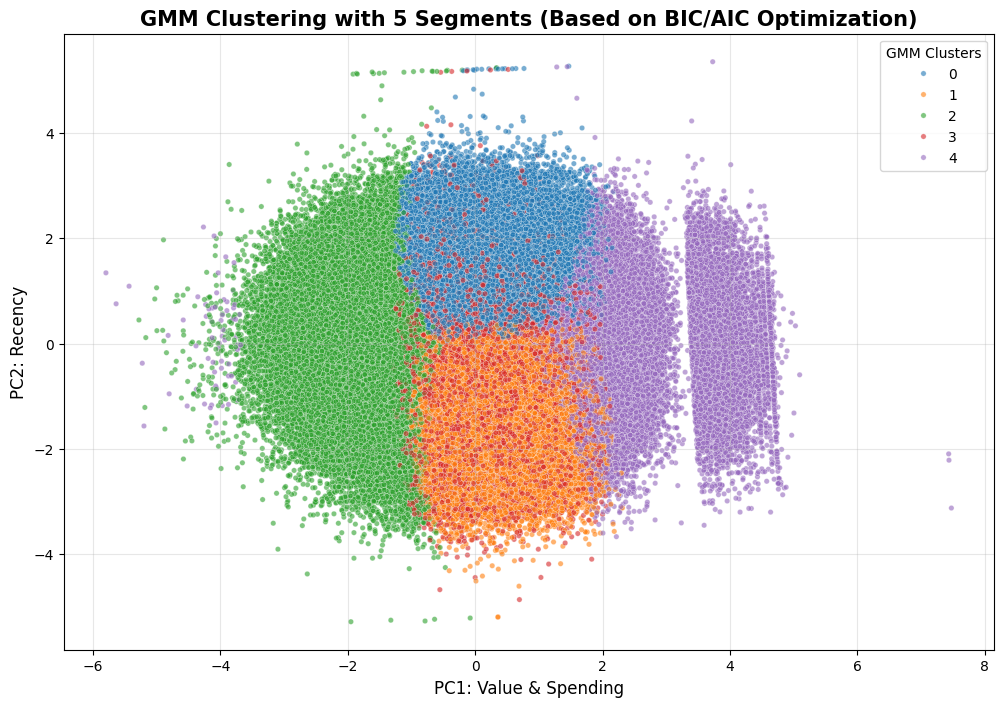

In [24]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=X_pca, 
    x='PC1', y='PC2', 
    hue=upc['GMM_Cluster_5'], 
    palette='tab10', 
    alpha=0.6, s=15
)

plt.title('GMM Clustering with 5 Segments (Based on BIC/AIC Optimization)', fontsize=15, fontweight='bold')
plt.xlabel('PC1: Value & Spending', fontsize=12)
plt.ylabel('PC2: Recency', fontsize=12)
plt.legend(title='GMM Clusters', loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()